In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
#Loading the Dataframe
Dataset = pd.read_pickle("Data_te_std.pkl")
Attack_label = pd.read_pickle("Attack_label.pkl")
Attack_type = pd.read_pickle("Attack_type.pkl")

# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset.shape[0],Dataset.shape[0]/5 , random_state=22)
Dataset_sampled = pd.DataFrame(Dataset.loc[indices.tolist()])
Attack_label_sampled = pd.DataFrame(Attack_label.loc[indices.tolist()])


# Checking distribution before and after sampling
print("Dataset Shape: ", Dataset_sampled.shape)
print("Before sampling: ", Attack_label.value_counts(normalize=True))
print("After sampling: ", Attack_label_sampled.value_counts(normalize=True))


Dataset Shape:  (31560, 36)
Before sampling:  Attack_label
1    0.846001
0    0.153999
Name: proportion, dtype: float64
After sampling:  Attack_label
1               0.8468
0               0.1532
Name: proportion, dtype: float64


In [3]:
# mapping and then sampling
mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
temp = Attack_type.map(mapping_dict)
Attack_type_sampled = pd.DataFrame(temp.loc[indices.tolist()])

print("Before sampling", Attack_type.value_counts(normalize=True))
print("After sampling", Attack_type_sampled.value_counts(normalize=True))

Before sampling Attack_type
Normal                   0.153999
DDoS_UDP                 0.091876
DDoS_ICMP                0.089290
Ransomware               0.069233
DDoS_HTTP                0.066926
SQL_injection            0.065342
Uploading                0.065076
DDoS_TCP                 0.064937
Backdoor                 0.064607
Vulnerability_scanner    0.063853
Port_Scanning            0.063821
XSS                      0.063701
Password                 0.063302
MITM                     0.007693
Fingerprinting           0.006343
Name: proportion, dtype: float64
After sampling Attack_type
1              0.312579
5              0.197782
4              0.196198
6              0.153200
2              0.133080
3              0.007161
Name: proportion, dtype: float64


In [4]:
X = Dataset_sampled.to_numpy() # 19725 sample
Yl = Attack_label_sampled.to_numpy(dtype='int')
Yt = Attack_type_sampled.to_numpy(dtype='int')

from sklearn.model_selection import train_test_split
# we need only around 3000 samples so test and training ratio can be only 0.2 and yet we get good result
X_train, X_test, Y_train, Y_test = train_test_split(X, Yt, test_size=0.8, random_state=22) 

## Linear SVC

In [17]:
from sklearn.svm import LinearSVC # one vs Rest/ one vs all
X_train, X_test, Y_train, Y_test = train_test_split(X, Yt, test_size=0.5, random_state=22) 
lin_svc = LinearSVC()
mult_clf = lin_svc.fit(X_train, Y_train)
Y_pred = mult_clf.predict(X_test)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.6136248415716097
F1 Score: 0.5670542826469607


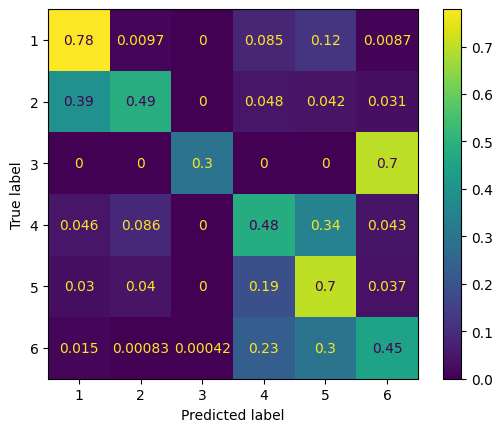

In [18]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

# Model F1-Score
print("F1 Score:", metrics.f1_score(Y_test, Y_pred, average="macro"))

cm = metrics.confusion_matrix(Y_test, Y_pred, labels=mult_clf.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mult_clf.classes_)
disp.plot()
plt.show()

## SVC

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

C_param = [1, 100, 500, 1000]
svc = SVC(kernel='rbf', decision_function_shape= 'ovo')
train_score, test_score = validation_curve(svc, X_train, Y_train, param_name= 'C', param_range= C_param, cv=2)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

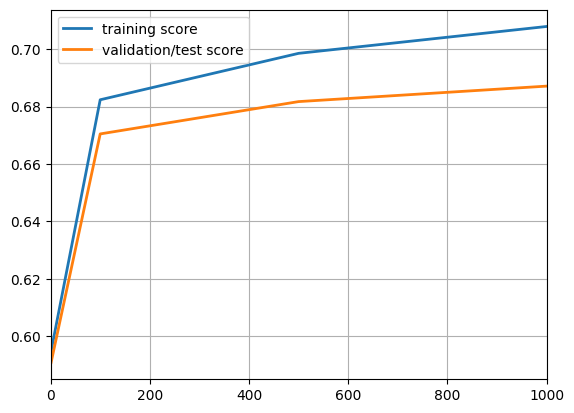

In [10]:
fig, ax = plt.subplots()
ax.grid()
ax.plot(C_param, train_score.mean(axis=1), linewidth=2.0, label = 'training score')
ax.plot(C_param, test_score.mean(axis=1), linewidth=2.0, label = 'validation/test score')
ax.set(xlim=(0, 1000))#, xticks=np.arange(1, 1e6, 1000))
plt.legend()
plt.show()

In [11]:
from sklearn.svm import SVC # one vs one
X_train, X_test, Y_train, Y_test = train_test_split(X, Yt, test_size=0.5, random_state=22) 
svc = SVC(kernel ='rbf', C= 1000, decision_function_shape= 'ovo')
mult_clf = svc.fit(X_train, Y_train)
Y_pred = mult_clf.predict(X_test)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.69702154626109
F1 Score: 0.6505462412912343


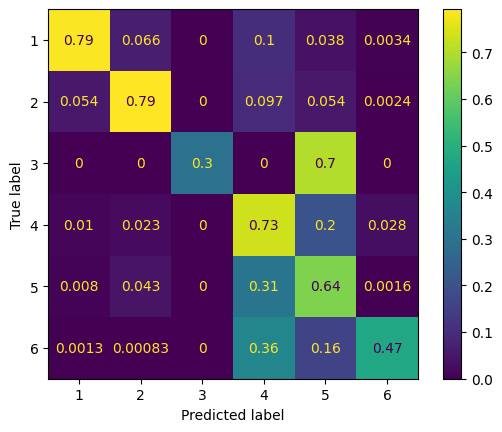

In [14]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

# Model F1-Score
print("F1 Score:", metrics.f1_score(Y_test, Y_pred, average="macro"))

cm = metrics.confusion_matrix(Y_test, Y_pred, labels=mult_clf.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mult_clf.classes_)
disp.plot()
plt.show()